# SARIMAX: Model selection, missing data

The example mirrors Durbin and Koopman (2012), Chapter 8.4 in application of Box-Jenkins methodology to fit ARMA models. The novel feature is the ability of the model to work on datasets with missing values.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [3]:
import requests
from io import BytesIO
from zipfile import ZipFile

# Download the dataset
dk = requests.get('http://www.ssfpack.com/files/DK-data.zip').content
f = BytesIO(dk)
zipped = ZipFile(f)
df = pd.read_table(
    BytesIO(zipped.read('internet.dat')),
    skiprows=1, header=None, sep='\s+', engine='python',
    names=['internet','dinternet']
)

### Model Selection

As in Durbin and Koopman, we force a number of the values to be missing.

In [4]:
# Get the basic series
dta_full = df.dinternet[1:].values
dta_miss = dta_full.copy()

# Remove datapoints
missing = np.r_[6,16,26,36,46,56,66,72,73,74,75,76,86,96]-1
dta_miss[missing] = np.nan

Then we can consider model selection using the Akaike information criteria (AIC), but running the model for each variant and selecting the model with the lowest AIC value.

There are a couple of things to note here:

- When running such a large batch of models, particularly when the autoregressive and moving average orders become large, there is the possibility of poor maximum likelihood convergence. Below we ignore the warnings since this example is illustrative.
- We use the option `enforce_invertibility=False`, which allows the moving average polynomial to be non-invertible, so that more of the models are estimable.
- Several of the models do not produce good results, and their AIC value is set to NaN. This is not surprising, as Durbin and Koopman note numerical problems with the high order models.

In [5]:
import warnings

aic_full = pd.DataFrame(np.zeros((6,6), dtype=float))
aic_miss = pd.DataFrame(np.zeros((6,6), dtype=float))

warnings.simplefilter('ignore')

# Iterate over all ARMA(p,q) models with p,q in [0,6]
for p in range(6):
    for q in range(6):
        if p == 0 and q == 0:
            continue
            
        # Estimate the model with no missing datapoints
        mod = sm.tsa.statespace.SARIMAX(dta_full, order=(p,0,q), enforce_invertibility=False)
        try:
            res = mod.fit(disp=False)
            aic_full.iloc[p,q] = res.aic
        except:
            aic_full.iloc[p,q] = np.nan
        
        # Estimate the model with missing datapoints
        mod = sm.tsa.statespace.SARIMAX(dta_miss, order=(p,0,q), enforce_invertibility=False)
        try:
            res = mod.fit(disp=False)
            aic_miss.iloc[p,q] = res.aic
        except:
            aic_miss.iloc[p,q] = np.nan

For the models estimated over the full (non-missing) dataset, the AIC chooses ARMA(1,1) or ARMA(3,0). Durbin and Koopman suggest the ARMA(1,1) specification is better due to parsimony.

$$
\text{Replication of:}\\
\textbf{Table 8.1} ~~ \text{AIC for different ARMA models.}\\
\newcommand{\r}[1]{{\color{red}{#1}}}
\begin{array}{lrrrrrr}
\hline
q &      0 &      1 &      2 &      3 &      4 &      5 \\
\hline
p &     {} &     {} &     {} &     {} &     {} &     {} \\
0 &   0.00 & 549.81 & 519.87 & 520.27 & 519.38 & 518.86 \\
1 & 529.24 & \r{514.30} & 516.25 & 514.58 & 515.10 & 516.28 \\
2 & 522.18 & 516.29 & 517.16 & 515.77 & 513.24 & 514.73 \\
3 & \r{511.99} & 513.94 & 515.92 & 512.06 & 513.72 & 514.50 \\
4 & 513.93 & 512.89 &    nan &    nan & 514.81 & 516.08 \\
5 & 515.86 & 517.64 &    nan &    nan &    nan &    nan \\
\hline
\end{array}
$$

For the models estimated over missing dataset, the AIC chooses ARMA(1,1)

$$
\text{Replication of:}\\
\textbf{Table 8.2} ~~ \text{AIC for different ARMA models with missing observations.}\\
\begin{array}{lrrrrrr}
\hline
q &      0 &      1 &      2 &      3 &      4 &      5 \\
\hline
p &     {} &     {} &     {} &     {} &     {} &     {} \\
0 &   0.00 & 488.93 & 464.01 & 463.86 & 462.63 & 463.62 \\
1 & 468.01 & \r{457.54} & 459.35 & 458.66 & 459.15 & 461.01 \\
2 & 469.68 &    nan & 460.48 & 459.43 & 459.23 & 460.47 \\
3 & 467.10 & 458.44 & 459.64 & 456.66 & 459.54 & 460.05 \\
4 & 469.00 & 459.52 &    nan & 463.04 & 459.35 & 460.96 \\
5 & 471.32 & 461.26 &    nan &    nan & 461.00 & 462.97 \\
\hline
\end{array}
$$

**Note**: the AIC values are calculated differently than in Durbin and Koopman, but show overall similar trends.

### Postestimation

Using the ARMA(1,1) specification selected above, we perform in-sample prediction and out-of-sample forecasting.

In [6]:
# Statespace
mod = sm.tsa.statespace.SARIMAX(dta_miss, order=(1,0,1))
res = mod.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   99
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -225.770
Date:                Tue, 02 Feb 2021   AIC                            457.541
Time:                        07:05:47   BIC                            465.326
Sample:                             0   HQIC                           460.691
                                 - 99                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6562      0.092      7.125      0.000       0.476       0.837
ma.L1          0.4878      0.111      4.390      0.000       0.270       0.706
sigma2        10.3402      1.569      6.591      0.0

[Text(0.5, 1.0, 'Figure 8.9 - Internet series')]

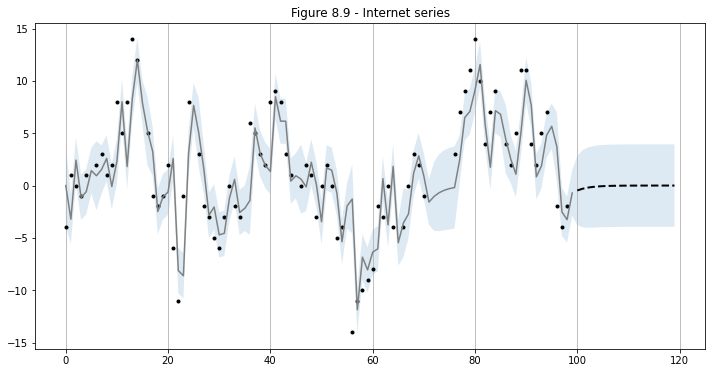

In [7]:
# In-sample one-step-ahead predictions, and out-of-sample forecasts
nforecast = 20
predict = res.get_prediction(end=mod.nobs + nforecast)
idx = np.arange(len(predict.predicted_mean))
predict_ci = predict.conf_int(alpha=0.5)

# Graph
fig, ax = plt.subplots(figsize=(12,6))
ax.xaxis.grid()
ax.plot(dta_miss, 'k.')

# Plot
ax.plot(idx[:-nforecast], predict.predicted_mean[:-nforecast], 'gray')
ax.plot(idx[-nforecast:], predict.predicted_mean[-nforecast:], 'k--', linestyle='--', linewidth=2)
ax.fill_between(idx, predict_ci[:, 0], predict_ci[:, 1], alpha=0.15)

ax.set(title='Figure 8.9 - Internet series');